# Rasterizing NC data

Let's convert the 2023_nc_july_7pm_avg data into a shape file, then rasterize it so it's in a half-km by half-km grid format.

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [2]:
nc_temp = pd.read_csv('2023_nc_july_7pm_avg.csv')
print(len(nc_temp))
nc_temp.head()

2008


,station,temp_eve,latitude,longitude,lat_m,lon_m
0,KGAHIAWA29,23.454839,34.98603,-83.70046,4.161983e+06,-9.317493e+06
1,KGAYOUNG52,23.790323,34.97200,-83.83600,4.160077e+06,-9.332581e+06
2,KNCABERD29,28.932258,35.17200,-79.51200,4.187280e+06,-8.851235e+06
3,KNCADVAN11,28.309677,35.98816,-80.42826,4.298992e+06,-8.953233e+06
4,KNCADVAN25,27.874194,35.98400,-80.44700,4.298420e+06,-8.955319e+06


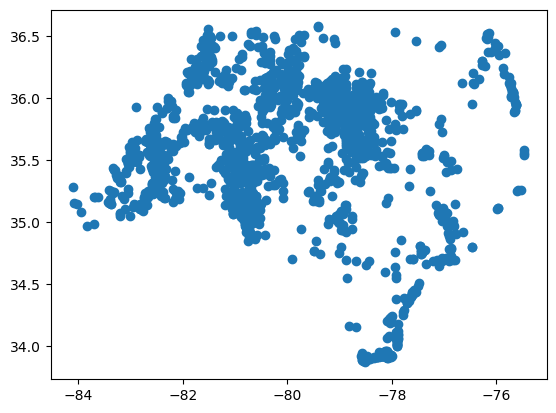

In [3]:
import matplotlib.pyplot as plt
plt.scatter(nc_temp['longitude'], nc_temp['latitude'])

### Create GDF and save as shapefile

In [4]:
geometry = [Point(xy) for xy in zip(nc_temp['lon_m'], nc_temp['lat_m'])]
gdf = gpd.GeoDataFrame(nc_temp, geometry=geometry)
gdf = gdf.set_crs(epsg=3857)  # Set the CRS to EPSG:3857 (meters) so that GPD can interpret data correctly

# Missing values are not present in the temp_eve column, so no need to remove them (we pre-selected stations with no missing temp values)

# Drop unnecessary columns
gdf = gdf.drop(['lat_m', 'lon_m', 'latitude', 'longitude'], axis=1)

# Add a column of ones (to use later on to count the number of stations in each cell)
gdf['ones'] = 1

# Save as a shapefile
gdf.to_file("nc_temp.shp")


In [5]:
print(gdf['temp_eve'].min(), gdf['temp_eve'].max())
print(gdf[gdf['temp_eve'] == 0])


18.887096774193548 30.43870967741936
Empty GeoDataFrame
Columns: [station, temp_eve, geometry, ones]
Index: []


In [6]:
# Check out metadata of shape file:
!ogrinfo nc_temp.shp nc_temp

INFO: Open of `nc_temp.shp'
      using driver `ESRI Shapefile' successful.

Layer name: nc_temp
Metadata:
  DBF_DATE_LAST_UPDATE=2025-01-15
Geometry: Point
Feature Count: 2008
Extent: (-9361700.895741, 4011359.531052) - (-8400836.692205, 4380586.155675)
Layer SRS WKT:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            MEMBER["World Geodetic System 1984 (G2139)"],
            MEMBER["World Geodetic System 1984 (G2296)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Gr

In [7]:
# Add a buffer of 10,000 meters (since we're doing NC and not just Durham now)
bounds = gdf.total_bounds
bounds = [bounds[0] - 1000, bounds[1] - 1000, bounds[2] + 1000, bounds[3] + 1000]

In [8]:
!gdal_rasterize -init 0.0 -add -a temp_eve -tap -te {bounds[0]} {bounds[1]} {bounds[2]} {bounds[3]}  -of GTIFF -l nc_temp -a_srs EPSG:3857 -tr 500 500 -ot Float64 -a_nodata -9999.0 nc_temp.shp nc_temp_500m.tif


0...10...20...30...40...50...60...70...80...90...100 - done.


Now let's open the TIF file and check that everything is as intended.

In [9]:
import numpy as np
import rasterio as rio   # library for reading and writing geospatial raster data

with rio.open('nc_temp_500m.tif') as src:
    temp_data = src.read(1)

for t in np.unique(temp_data):
    print(t)

0.0
18.887096774193548
18.98709677419355
19.05161290322581
19.067741935483877
19.293548387096777
19.30322580645161
19.4741935483871
19.574193548387097
19.758064516129032
20.293548387096777
20.37741935483871
20.45483870967742
20.490322580645163
20.54516129032258
20.69677419354839
20.774193548387096
20.85483870967742
20.961290322580645
20.96451612903226
21.029032258064515
21.05161290322581
21.05806451612903
21.11935483870968
21.138709677419357
21.206451612903223
21.26451612903226
21.280645161290323
21.30322580645161
21.34193548387097
21.374193548387098
21.387096774193548
21.51935483870968
21.53548387096774
21.55161290322581
21.580645161290324
21.583870967741937
21.58709677419355
21.60322580645161
21.648387096774197
21.67419354838709
21.69032258064516
21.712903225806453
21.72903225806452
21.73225806451613
21.741935483870968
21.76129032258065
21.76451612903226
21.787096774193547
21.845161290322583
21.858064516129037
21.9
21.91935483870968
21.925806451612903
21.93548387096774
21.95161290322

In [10]:
temp_data.shape

(744, 1927)

vmin: 0.0, vmax: 59.16451612903226
Cropped data vmin: 0.0, vmax: 58.26129032258064


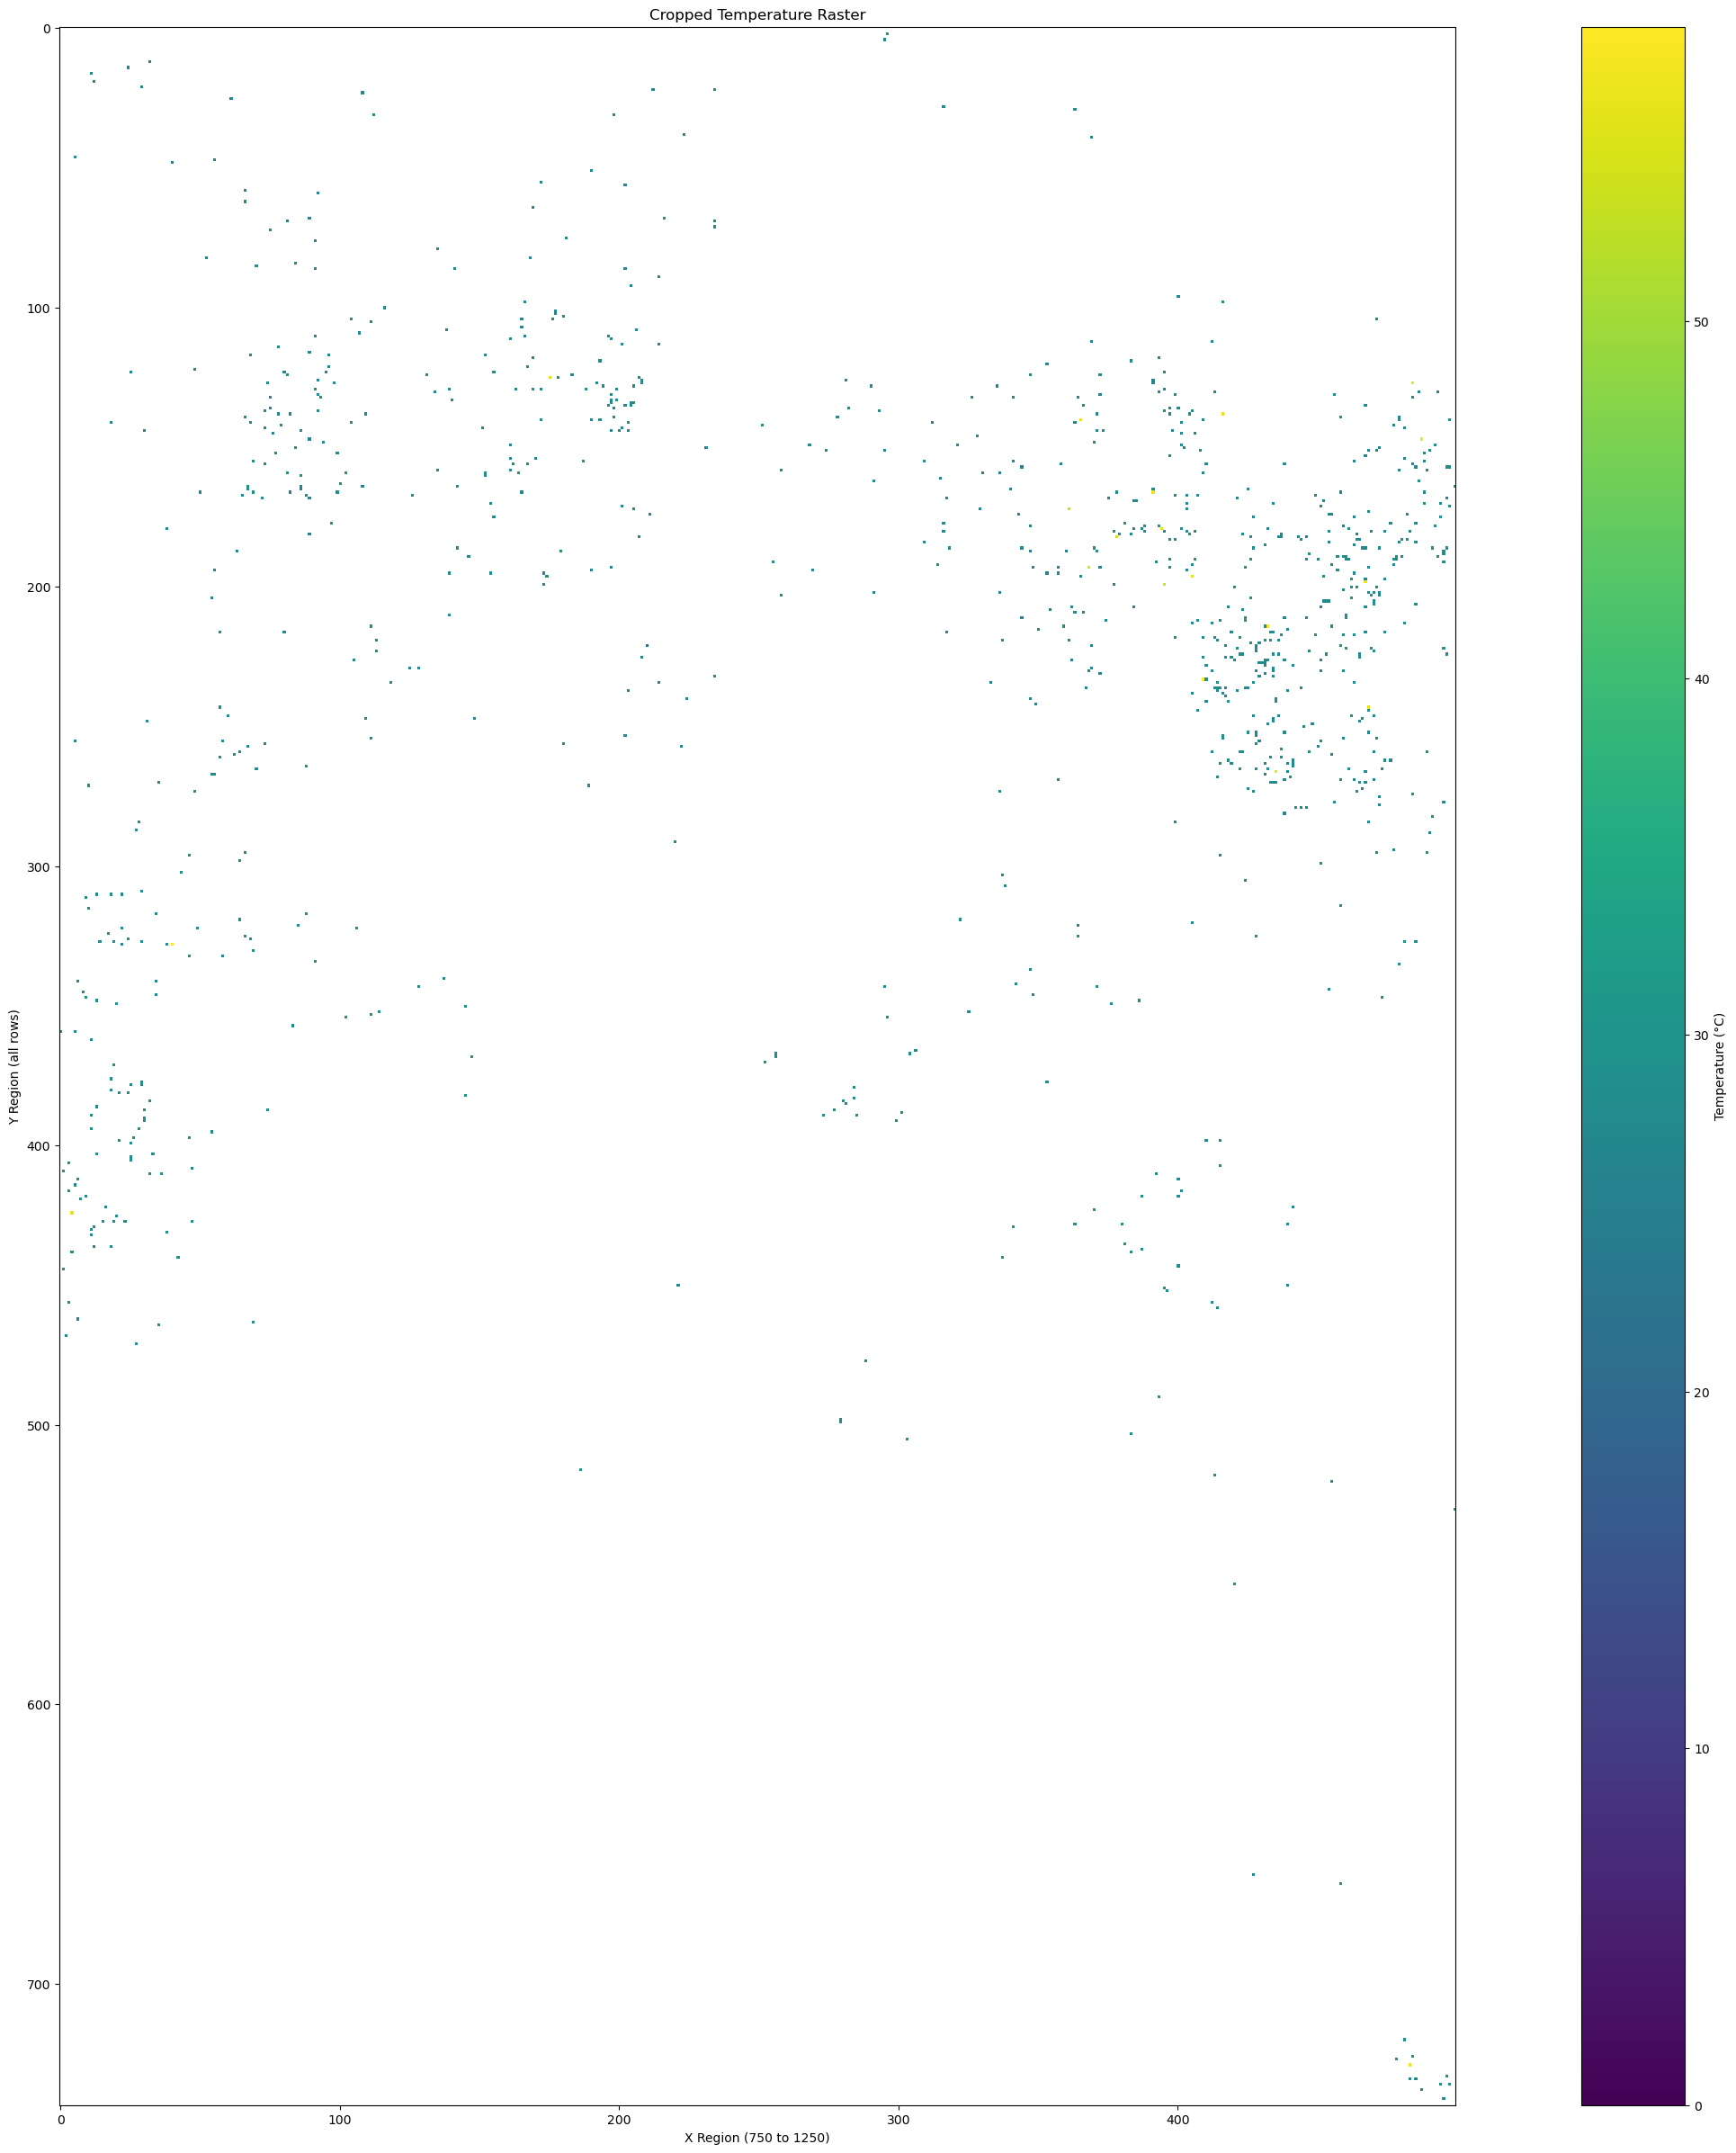

In [11]:
# Set up colormap
cmap = plt.cm.viridis.copy()
cmap.set_bad(color="white")  # NaN values appear white

# Define color range based on valid data
vmin = np.nanmin(temp_data)
vmax = np.nanmax(temp_data)
print(f"vmin: {vmin}, vmax: {vmax}")

# Define crop region: middle third of x (columns 750 to 1250) and all y (rows)
x_start, x_end = 750, 1250
cropped_data = temp_data[:, x_start:x_end]

# Ensure colormap range aligns with cropped data
vmin = np.nanmin(cropped_data)
vmax = np.nanmax(cropped_data)
print(f"Cropped data vmin: {vmin}, vmax: {vmax}")

# Plot the cropped data
plt.figure(figsize=(36, 30))

temp_data[temp_data == 0] = np.nan
temp_data[temp_data == -9999] = np.nan

cmap = plt.cm.viridis.copy()
cmap.set_bad(color="white")  # Set NaN areas to white
plt.imshow(cropped_data, cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar(label="Temperature (°C)")
plt.title("Cropped Temperature Raster")
plt.xlabel(f"X Region ({x_start} to {x_end})")
plt.ylabel("Y Region (all rows)")
plt.show()


Overall data vmin: 18.887096774193548, vmax: 59.16451612903226


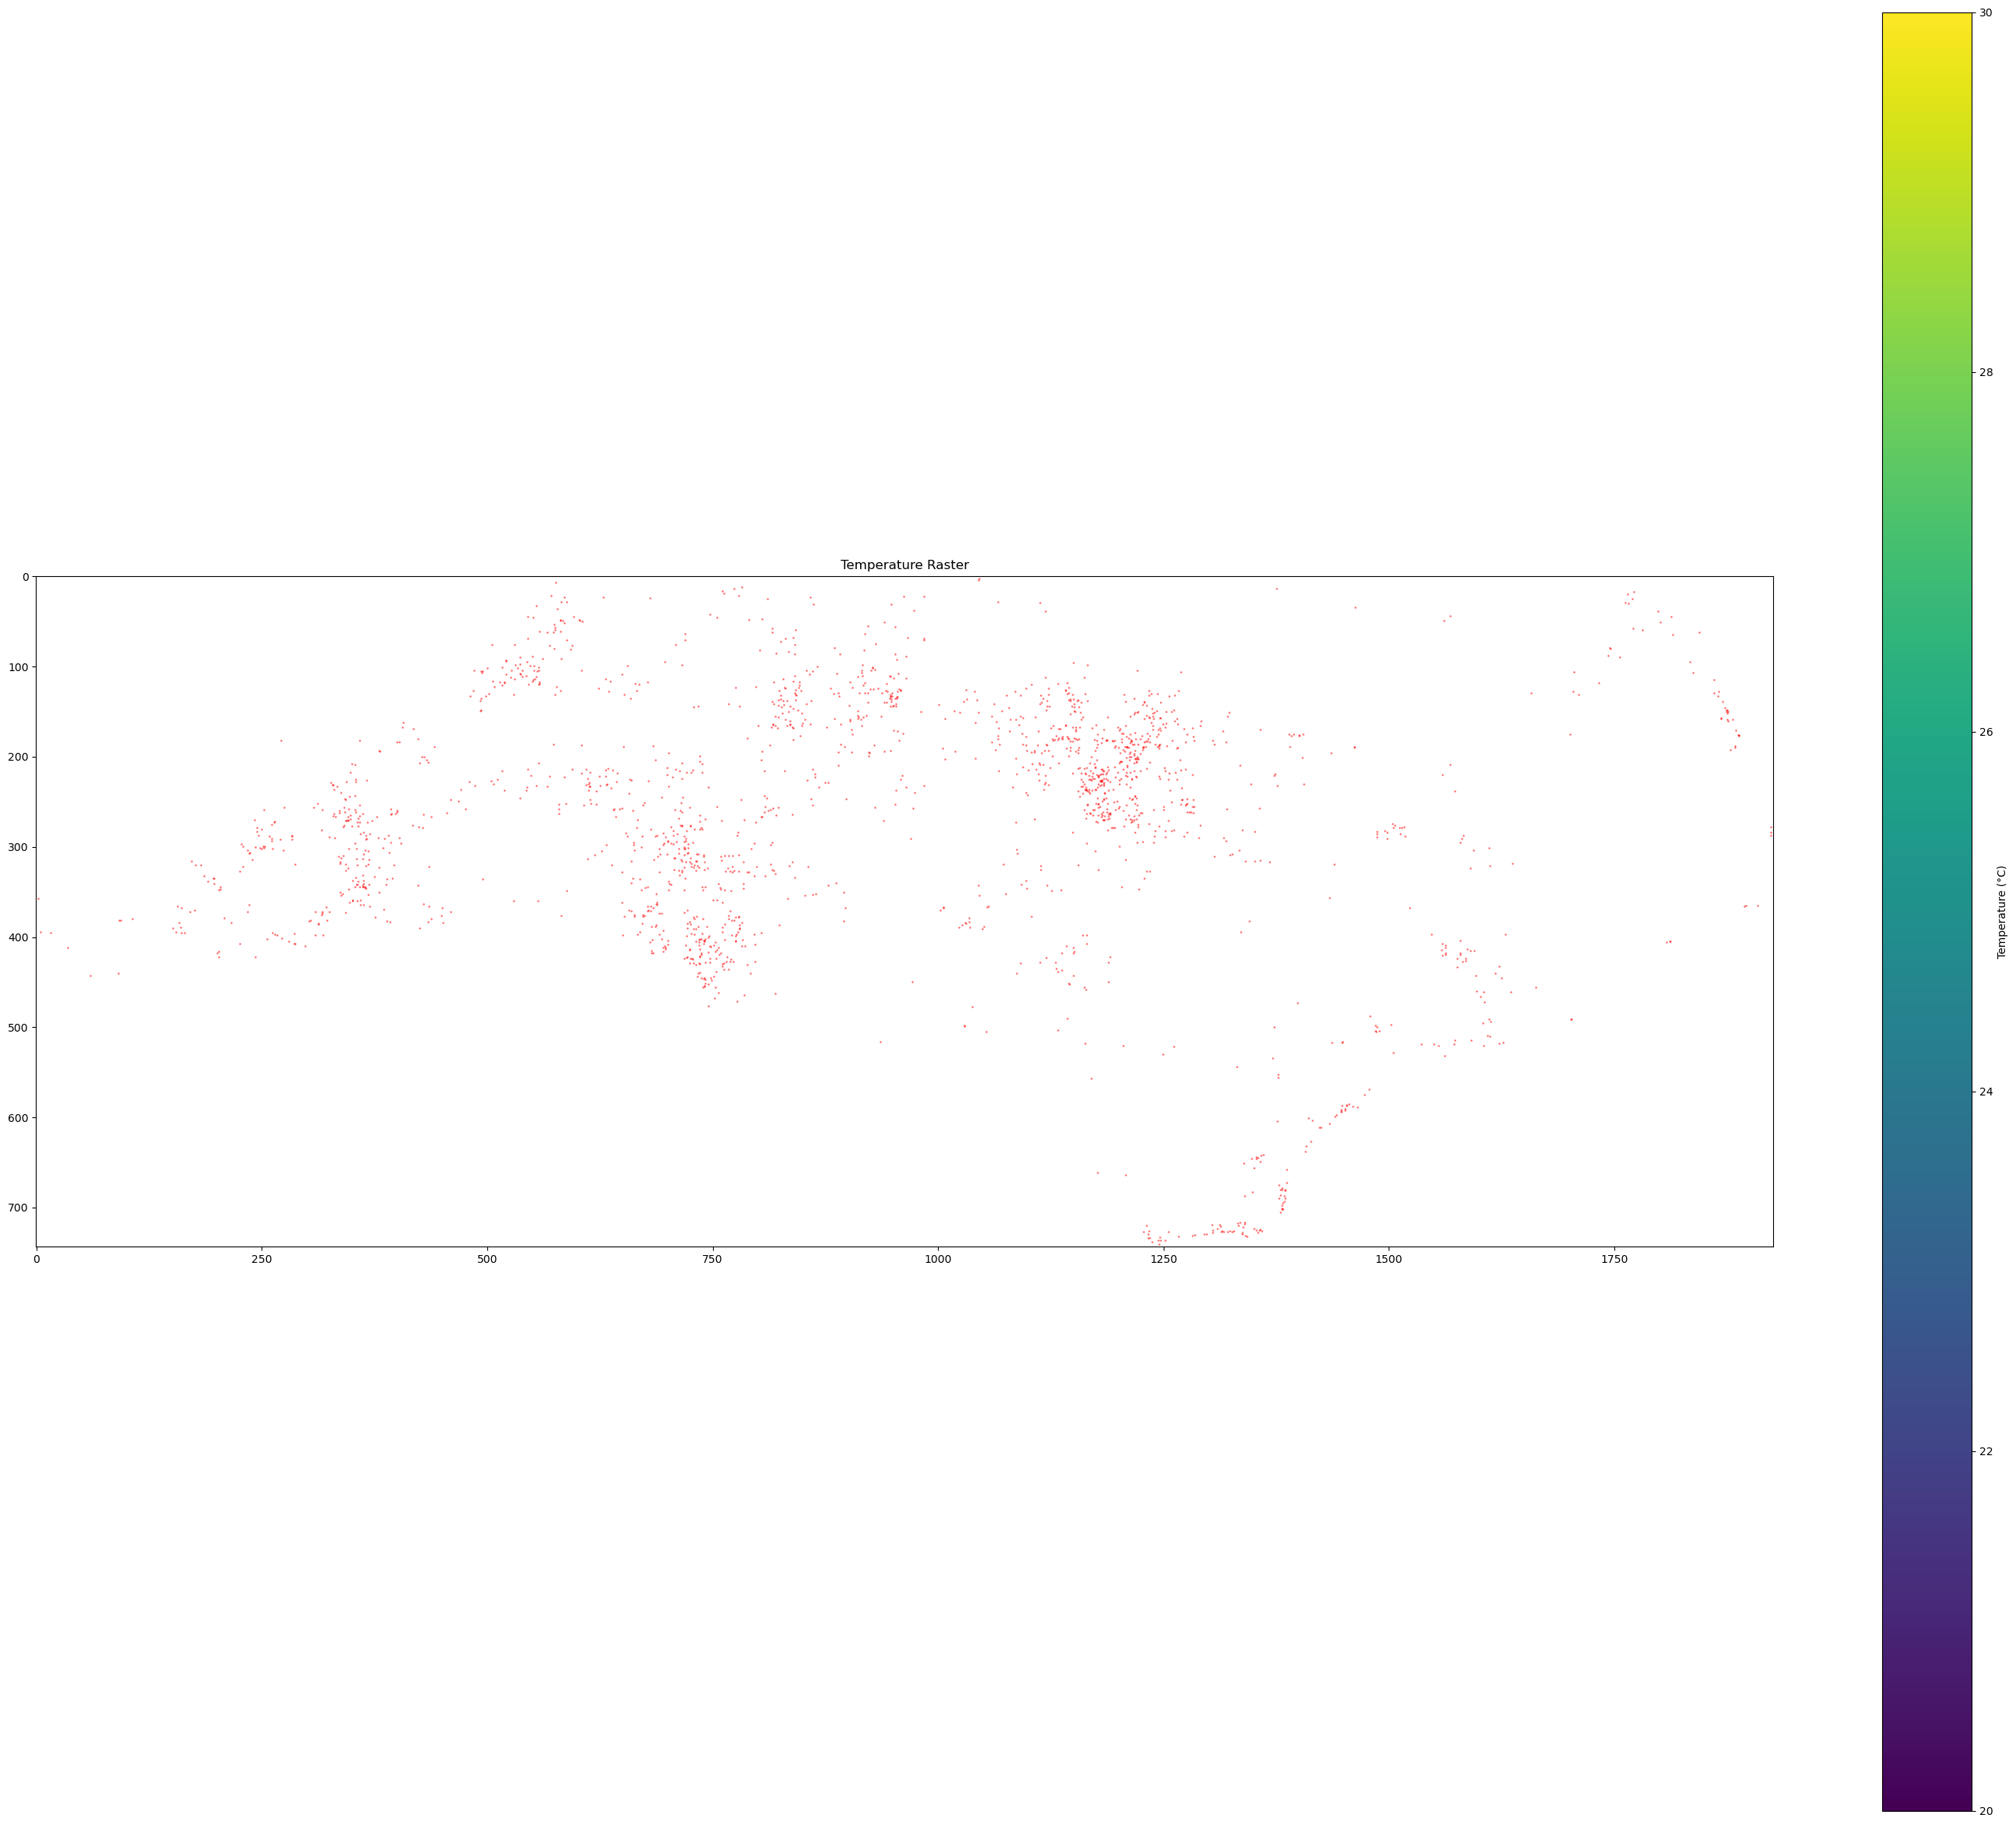

In [12]:
# Plot the raster with informative colormap

vmin = np.nanmin(temp_data)
vmax = np.nanmax(temp_data)
print(f"Overall data vmin: {vmin}, vmax: {vmax}")

plt.figure(figsize=(36, 30))
plt.imshow(temp_data, cmap=cmap, vmin=20, vmax=30)
plt.colorbar(label="Temperature (°C)")
plt.title("Temperature Raster")

valid_x, valid_y = np.where(~np.isnan(temp_data))  # Get coordinates of valid data
plt.scatter(valid_y, valid_x, color='red', s=1, alpha=0.4)  # Overlay dots

plt.show()

Note to viewer: 

In [13]:
# Inspect the range of values
print(f"Raster shape: {temp_data.shape}")
print(f"Unique values in raster: {np.unique(temp_data)}")
print(f"Min valid temp: {np.min(temp_data)}, Max valid temp: {np.max(temp_data)}")
print(f"Count of valid (non-zero) cells: {np.count_nonzero(temp_data)}")
print(f"Count of zero cells: {np.count_nonzero(temp_data == 0.0)}")




Raster shape: (744, 1927)
Unique values in raster: [18.88709677 18.98709677 19.0516129  ... 59.08387097 59.16451613
         nan]
Min valid temp: nan, Max valid temp: nan
Count of valid (non-zero) cells: 1433688
Count of zero cells: 0
